# Определение перспективного тарифа для телеком-компании

Федеральный оператор сотовой связи "Мегалайн" предлагает клиентам два тарифных плана - "Смарт" и "Ультра". Надо понять, какой тариф приносит больше денег, проверив две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Параметры тарифов собраны в таблицу.

 Опции| Смарт| Ультра
------ | ------| ------
Ежемесячная плата, руб   | 550  | 1950  
Минут разговора в пакете   | 500  | 3000 
Сообщений в пакете   | 50  | 1000 
Гб интернет-трафика в пакете   | 15  | 30
Минута разговора сверх тарифа, руб   | 3  | 1 
Сообщение сверх тарифа, руб   | 3  | 1 
1 Гб интернет-трафика сверх тарифа, руб   | 200  | 150 

Секунды округляются до минут, мегабайты до гигабайт, неиспользованные остатки с прошлого месяца не переносятся в новый месяц.

## Изучение данных

Для исследования есть 5 csv-файлов с данными:
- *calls*, информация о звонках
- *messages*, информация о сообщениях
- *internet*, информация об интернет-сессиях
- *users*, информация о пользователях
- *tariffs*, информация о тарифах

Импортируем библиотеки и загрузим данные.

In [1]:
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
import numpy

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

Изучим полученные данные.

In [3]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [4]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица `tariffs` содержит информацию о двух тарифах.

In [5]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [8]:
# Выведем на экран уникальные значения всех текстовых переменных.
for col in users.columns:   
    if users[col].dtype == "object":
        print(col)
        print(users[col].unique())
        print()

churn_date
[nan '2018-10-05' '2018-12-18' '2018-11-21' '2018-10-03' '2018-10-14'
 '2018-12-09' '2018-12-11' '2018-12-26' '2018-08-31' '2018-12-03'
 '2018-12-23' '2018-11-07' '2018-12-16' '2018-12-20' '2018-11-30'
 '2018-12-21' '2018-08-17' '2018-09-02' '2018-10-04' '2018-11-13'
 '2018-11-22' '2018-10-28' '2018-11-26' '2018-11-27' '2018-11-16'
 '2018-10-27' '2018-12-30' '2018-09-27' '2018-12-25' '2018-12-14'
 '2018-12-24' '2018-09-26' '2018-10-25']

city
['Краснодар' 'Москва' 'Стерлитамак' 'Новокузнецк' 'Набережные Челны'
 'Ульяновск' 'Челябинск' 'Пермь' 'Тюмень' 'Самара' 'Санкт-Петербург'
 'Иваново' 'Чебоксары' 'Омск' 'Уфа' 'Томск' 'Чита' 'Мурманск'
 'Петрозаводск' 'Тверь' 'Екатеринбург' 'Махачкала' 'Вологда' 'Череповец'
 'Ярославль' 'Сочи' 'Хабаровск' 'Ставрополь' 'Рязань' 'Улан-Удэ' 'Тула'
 'Саратов' 'Ростов-на-Дону' 'Казань' 'Иркутск' 'Курск' 'Калуга' 'Якутск'
 'Астрахань' 'Химки' 'Владикавказ' 'Волгоград' 'Саранск' 'Ижевск'
 'Новосибирск' 'Брянск' 'Тольятти' 'Нижний Тагил' 'Орёл' '

В `users` содержится информация о пользователях с id от 1000 до 1499 - всего 500 пользователей от 18 до 75 лет.

`churn_date` - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).
У `churn_date` и `reg_date` неверный тип данных. Это даты, а не текст.

In [9]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [11]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


В `calls` содержится информация о длительности 202606 звонков. Пропущенные звонки отображаются с длительностью 0. Максимальная продолжительность звонка - 38 минут, в среднем звонок длится 7 минут. Выглядит правдоподобно.

Поле `call_date` требует замены типа данных на datetime.

In [12]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В `messages` содержится информация об отправленных сообщениях. 

Поле `message_date` требует замены типа данных на datetime.

In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [15]:
internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
80490,80490,1271_47,14.18,2018-10-31,1271
129179,129179,1431_213,0.38,2018-05-29,1431
30077,30077,1105_145,797.74,2018-10-21,1105
91988,91988,1311_98,1252.40,2018-12-22,1311
131433,131433,1436_399,566.38,2018-10-24,1436


In [16]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


В `internet` содержится информация об интернет-сессиях и потраченных мегабайтах. В среднем за одну сессию пользователи тратят 370 мегабайтов, данные выглядят достоверно, но нужно проверить сессии с нулевым расходом мегабайтов.

Поле `session_date` требует замены типа данных на datetime. Колонка `Unnamed: 0` дублирует значения индекса, её можно удалить.

In [17]:
internet.drop('Unnamed: 0', axis=1)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


Проверим все таблицы, кроме `tariffs` на наличие дублей.

In [18]:
print('Количество дублей в users:', users.duplicated().sum())
print('Количество дублей в messages:', users.duplicated().sum())
print('Количество дублей в calls:', users.duplicated().sum())
print('Количество дублей в internet:', users.duplicated().sum())

Количество дублей в users: 0
Количество дублей в messages: 0
Количество дублей в calls: 0
Количество дублей в internet: 0


### Вывод

Мы загрузили и изучили данные из пяти файлов. По результату исследования данных обнаружены следующие ошибки:
1. Поле `mb_used` (количество использованных мегабайтов) в `internet` иногда принимает нулевое значение, нужно исследовать эти случаи.
2. Типы данных в колонках `churn_date`, `reg_date` (таблица `users`), `call_date` (таблица `calls`), `message_date` (таблица `messages`) и `session_date` (таблица `internet`) некорректны, их нужно сменить на datetime.
3. Дублей, аномальных значений, необоснованных пропусков в данных не обнаружено.

## Предобработка данных

### Исследование аномальных значений

Проверим интернет-сессии с 0 потраченных мегабайтов.

In [19]:
internet[internet['mb_used']==0]

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


Таких сессий почти 20 тысяч. Возможно, это какие-то служебные сессии, фоновые обновления, которые тратят настолько мало мегабайтов, что в данной таблице с округлением числа до одного знака после запятой, они отображаются как нули. Избавися от данных записей, т.к. их нельзя считать полноценными пользовательскими интернет-сессиями.

In [20]:
internet = internet[internet['mb_used']>0]

### Преобразование типов данных

Приведем все даты к типу datetime.

In [21]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

### Дополнительные расчёты

Каждый звонок клиента всегда округляется в большую сторону до минуты: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Округлим данные по звонкам в таблице `calls`.

In [22]:
calls['duration'] = numpy.ceil(calls['duration']).astype('int')

Для удобства дальнейших расчётов добавим в таблицы с данными по звонкам, сообщениям и интернет-сессиям дополнительный столбец, содержащий числовое значение месяца. Год можно не добавлять, т.к. мы знаем, что данные только за 2018 год.

In [23]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

### Вывод

В данном разделе мы провели предобработку данных, удалив аномальные интернет-сессии, в которых затраты трафика равны нулю мегабайтов, а также привели все даты к типу datetime. 
Последним этапом были добавлены номера месяцев в таблицы `calls`, `messages` и `internet`, минуты звонков округлены в большую сторону.

## Исследовательский анализ

Подготовим данные для исследовательского анализа. Для этого соберём данные из четырёх таблиц в одну сводную по каждому пользователю за каждый месяц.

In [24]:
# Соединим calls с messages, выведем сумму длительности звонков и количество сообщений за каждый месяц.
stat = calls.pivot_table(index=['user_id','month'],
                                        values='duration',
                                        aggfunc='sum').reset_index().merge(messages.pivot_table(index=['user_id','month'],
                                        values='message_date',
                                        aggfunc='count').reset_index(), on=['user_id','month'],how='outer'
                  )
stat

,user_id,month,duration,message_date
0,1000,5,159.0,22.0
1,1000,6,172.0,60.0
2,1000,7,340.0,75.0
3,1000,8,408.0,81.0
4,1000,9,466.0,57.0
...,...,...,...,...
3208,1489,8,NaN,17.0
3209,1489,9,NaN,32.0
3210,1489,10,NaN,21.0
3211,1489,11,NaN,20.0


In [25]:
# Добавим internet, выведем суммарных расход мегабайтов за каждый месяц.
stat = stat.merge(internet.pivot_table(index=['user_id','month'],
                                       values='mb_used',
                                       aggfunc='sum'),
                  on=['user_id','month'],
                  how='outer')
stat

,user_id,month,duration,message_date,mb_used
0,1000,5,159.0,22.0,2253.49
1,1000,6,172.0,60.0,23233.77
2,1000,7,340.0,75.0,14003.64
3,1000,8,408.0,81.0,14055.93
4,1000,9,466.0,57.0,14568.91
...,...,...,...,...,...
3209,1489,9,NaN,32.0,17206.30
3210,1489,10,NaN,21.0,19559.44
3211,1489,11,NaN,20.0,17491.56
3212,1489,12,NaN,35.0,17322.51


In [26]:
# Добавим информацию из users.
stat = stat.merge(users[['user_id','city','tariff']],
                  on=['user_id'],
                  how='left')
stat

,user_id,month,duration,message_date,mb_used,city,tariff
0,1000,5,159.0,22.0,2253.49,Краснодар,ultra
1,1000,6,172.0,60.0,23233.77,Краснодар,ultra
2,1000,7,340.0,75.0,14003.64,Краснодар,ultra
3,1000,8,408.0,81.0,14055.93,Краснодар,ultra
4,1000,9,466.0,57.0,14568.91,Краснодар,ultra
...,...,...,...,...,...,...,...
3209,1489,9,NaN,32.0,17206.30,Санкт-Петербург,smart
3210,1489,10,NaN,21.0,19559.44,Санкт-Петербург,smart
3211,1489,11,NaN,20.0,17491.56,Санкт-Петербург,smart
3212,1489,12,NaN,35.0,17322.51,Санкт-Петербург,smart


Взглянем на получившуюся таблицу.

In [27]:
stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3214 non-null   int64  
 1   month         3214 non-null   int64  
 2   duration      3174 non-null   float64
 3   message_date  2717 non-null   float64
 4   mb_used       3201 non-null   float64
 5   city          3214 non-null   object 
 6   tariff        3214 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 200.9+ KB


Дадим колонкам понятные имена.

In [28]:
stat = stat[['user_id','city','tariff','month','duration','message_date','mb_used']]
columns = ['user_id','city','tariff_name','month','minutes','messages','internet']
stat.columns=columns

В `messages`, `minutes` и `internet` появились пропуски - 497 клиентов не отправляют смс-сообщения, 40 не используют звонки, а 13 не пользуются мобильным интернетом. Заполним пропуски нулями, переведём мегабайты в гигабайты и приведём типы данных к int.

In [29]:
stat['messages'] = stat['messages'].fillna(0).astype('int')
stat['internet'] = stat['internet'].fillna(0)
stat['internet'] = numpy.ceil(stat['internet']/1024).astype('int')
stat['minutes'] = stat['minutes'].fillna(0).astype('int')

In [30]:
stat.head()

,user_id,city,tariff_name,month,minutes,messages,internet
0,1000,Краснодар,ultra,5,159,22,3
1,1000,Краснодар,ultra,6,172,60,23
2,1000,Краснодар,ultra,7,340,75,14
3,1000,Краснодар,ultra,8,408,81,14
4,1000,Краснодар,ultra,9,466,57,15


Сводная таблица готова. Теперь для каждой строки нужно посчитать итоговую выручку. Для начала, присоединим таблицу с тарифами к итоговой таблице для удобства построчной обработки данных.

In [31]:
stat = stat.merge(tariffs, on='tariff_name')
stat

,user_id,city,tariff_name,month,minutes,messages,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Краснодар,ultra,5,159,22,3,1000,30720,3000,1950,150,1,1
1,1000,Краснодар,ultra,6,172,60,23,1000,30720,3000,1950,150,1,1
2,1000,Краснодар,ultra,7,340,75,14,1000,30720,3000,1950,150,1,1
3,1000,Краснодар,ultra,8,408,81,14,1000,30720,3000,1950,150,1,1
4,1000,Краснодар,ultra,9,466,57,15,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,Санкт-Петербург,smart,8,0,17,11,50,15360,500,550,200,3,3
3210,1489,Санкт-Петербург,smart,9,0,32,17,50,15360,500,550,200,3,3
3211,1489,Санкт-Петербург,smart,10,0,21,20,50,15360,500,550,200,3,3
3212,1489,Санкт-Петербург,smart,11,0,20,18,50,15360,500,550,200,3,3


Напишем функцию-обработчик.

In [32]:
def income(row):
    # Функция считает итоговую выручку компании, учитывая параметры каждого тарифа.
    income = row['rub_monthly_fee']
    # Считаем переплату за минуты.
    if row['minutes'] > row['minutes_included']:
        income+=(row['minutes']-row['minutes_included'])*row['rub_per_minute']
    # Считаем переплату за сообщения.
    if row['messages'] > row['messages_included']:
        income+=(row['messages']-row['messages_included'])*row['rub_per_message']
    # Считаем переплату за интернет.
    if row['internet'] > row['mb_per_month_included']/1024:
        income+=(row['internet']-row['mb_per_month_included']/1024)*row['rub_per_gb']
    return int(income)

In [33]:
stat['income'] = stat.apply(income, axis=1)
columns.append('income')
stat = stat[columns]
stat

,user_id,city,tariff_name,month,minutes,messages,internet,income
0,1000,Краснодар,ultra,5,159,22,3,1950
1,1000,Краснодар,ultra,6,172,60,23,1950
2,1000,Краснодар,ultra,7,340,75,14,1950
3,1000,Краснодар,ultra,8,408,81,14,1950
4,1000,Краснодар,ultra,9,466,57,15,1950
...,...,...,...,...,...,...,...,...
3209,1489,Санкт-Петербург,smart,8,0,17,11,550
3210,1489,Санкт-Петербург,smart,9,0,32,17,950
3211,1489,Санкт-Петербург,smart,10,0,21,20,1550
3212,1489,Санкт-Петербург,smart,11,0,20,18,1150


Сводная таблица со всеми данными готова. Изучим поведение клиентов каждого тарифа, исходя из выборки.

Тариф smart

minutes
Количество абонентов: 2229
Выборочное среднее: 417.9349484073576
Выборочная дисперсия: 36219.31578434428
Выборочное стандартное отклонение: 190.31372988921288


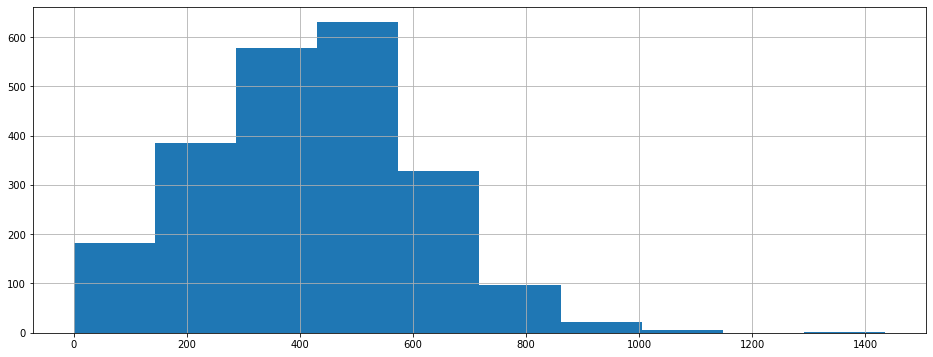


messages
Количество абонентов: 2229
Выборочное среднее: 33.384028712427096
Выборочная дисперсия: 796.8129584480083
Выборочное стандартное отклонение: 28.22787555676141


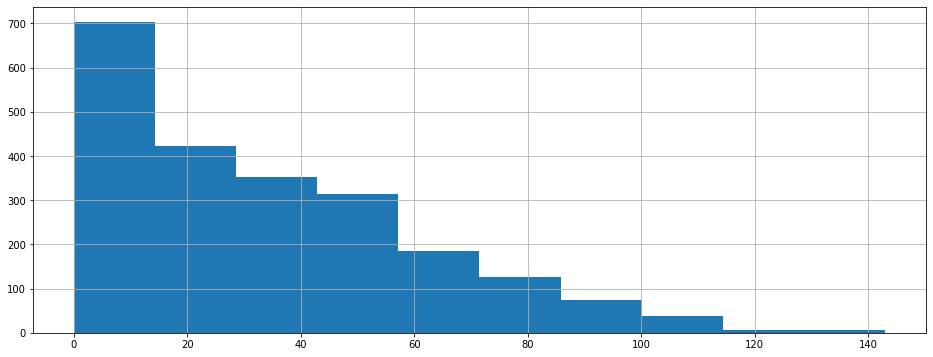


internet
Количество абонентов: 2229
Выборочное среднее: 16.328847016599372
Выборочная дисперсия: 33.02870517811161
Выборочное стандартное отклонение: 5.7470605685090534


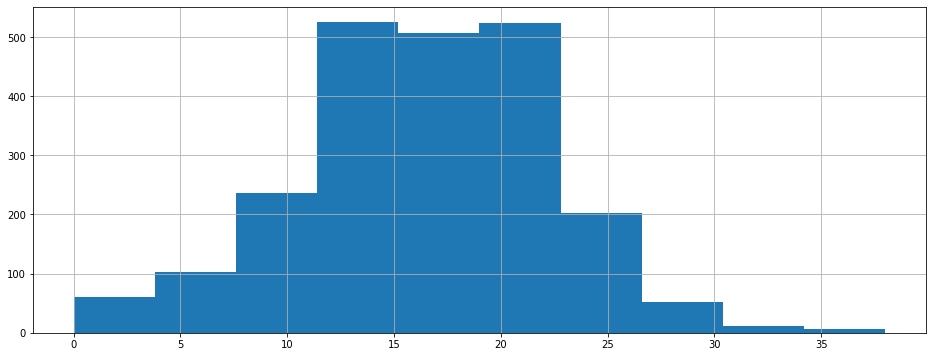


income
Количество абонентов: 2229
Выборочное среднее: 1289.9735307312696
Выборочная дисперсия: 669785.7080064242
Выборочное стандартное отклонение: 818.4043670499469


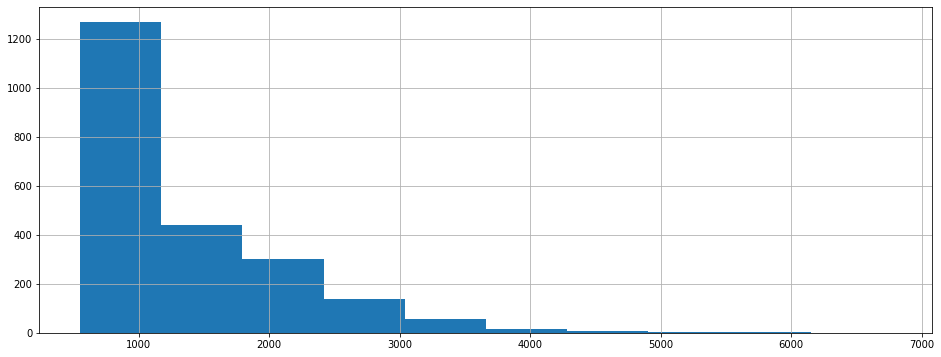


Тариф ultra

minutes
Количество абонентов: 985
Выборочное среднее: 526.6233502538071
Выборочная дисперсия: 100873.63339730098
Выборочное стандартное отклонение: 317.6060978591264


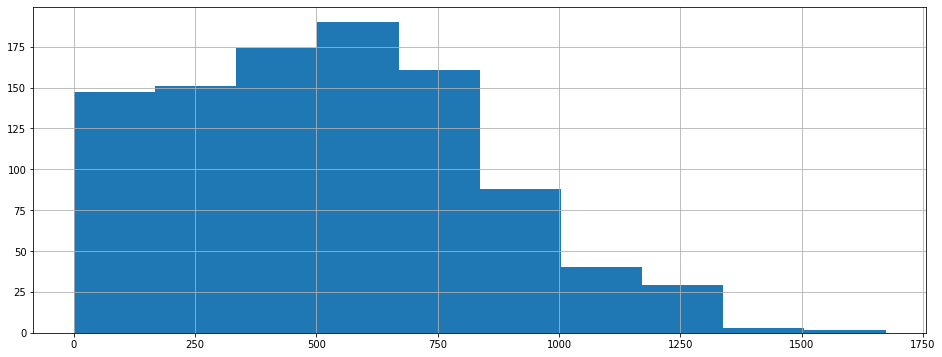


messages
Количество абонентов: 985
Выборочное среднее: 49.36345177664975
Выборочная дисперсия: 2285.2661425446736
Выборочное стандартное отклонение: 47.804457350174715


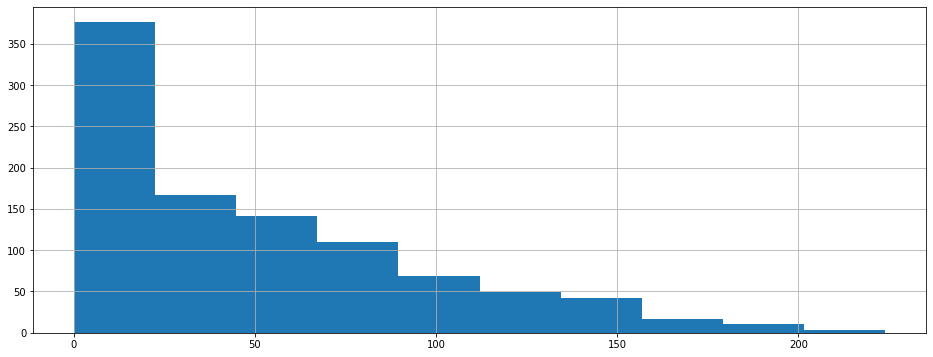


internet
Количество абонентов: 985
Выборочное среднее: 19.494416243654822
Выборочная дисперсия: 97.09168626965459
Выборочное стандартное отклонение: 9.853511367510293


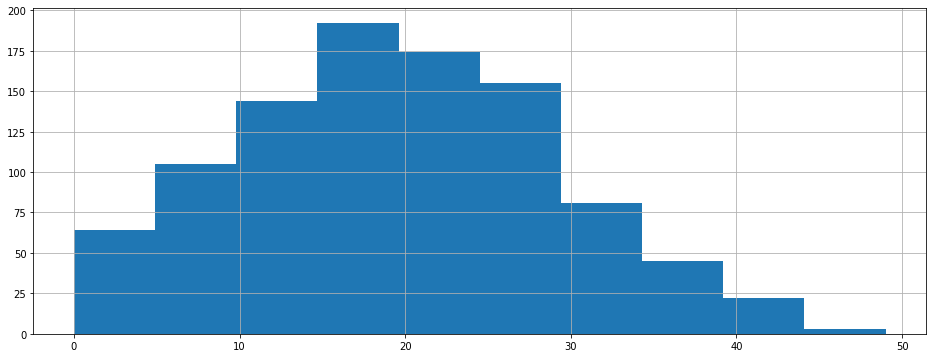


income
Количество абонентов: 985
Выборочное среднее: 2070.1522842639592
Выборочная дисперсия: 141516.7450786183
Выборочное стандартное отклонение: 376.1871144505328


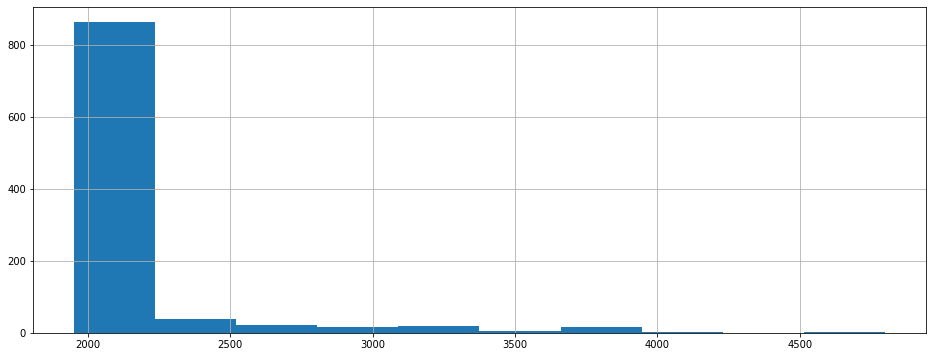

In [34]:
for tariff in ('smart', 'ultra'):
    print('Тариф', tariff)
    print()
    for col in columns[4:]:
        print(col)
        print('Количество абонентов:',stat[stat['tariff_name']==tariff][col].count())
        print('Выборочное среднее:',stat[stat['tariff_name']==tariff][col].mean())
        print('Выборочная дисперсия:',numpy.var(stat[stat['tariff_name']==tariff][col], ddof=1))
        print('Выборочное стандартное отклонение:',numpy.std(stat[stat['tariff_name']==tariff][col], ddof=1))
        stat[stat['tariff_name']==tariff][col].hist(figsize=(16,6))
        plt.show()
        print()
        

У тарифа «Смарт» более чем в два раза больше абонентов, в среднем в месяц они тратят 420 минут на разговоры, 33 сообщения, что вмещается в пакет из 500 минут и 50 сообщений, но переплаты по этим пакетам также иногда случаются. А вот объём потраченного интернета часто оказывается за пределами 15 Гб, включённых в пакет. В среднем пользователям этого тарифа надо 16 Гб в месяц.

Пользователи тарифа «Ультра» тратят в среднем 545 минут на разговоры и 49 сообщений в месяц и никогда не превышают лимит этих пакетов (3000 минут и 1000 сообщений). Интернета в среднем требуется 19 Гб, что и близко не превышает пакет из 30 Гб, но переплаты по этому пакету иногда случаются. 

Графики траты минут и сообщений представляют собой нормальное распределение, скошенное вправо. А графики траты трафика мобильного интернета тяготеют к симметричному нормальному распределению. Это может говорить о том, что современные пользователи всё меньше используют мобильную связь и смс-сообщения, предпочитая совершать звонки и отправлять сообщения по интернету.

В среднем выручка от абонентов тарифа «Смарт» около 1200 рублей в месяц, а тарифа «Ультра» - чуть больше 2000 в месяц. Однако пользователи тарифа «Смарт» чаще не укладываются в лимит и переплачивают за свой тариф, что видно по гистограммам показателя *income*.

### Вывод

1. Пользователи тарифа «Смарт» чаще платят сверх тарифа и часто не укладываются в лимит интернет-трафика, а пользователи тарифа «Ультра» никогда не расходуют свои пакеты минут и сообщений до конца, но иногда превышают лимит пакета мобильного интренета.
2. Несмотря на частые переплаты сверх тарифа «Смарт», среднемесячный доход от тарифа «Ультра» больше дохода от тарифа «Смарт» почти в два раза.
3. Исходя из исследовательского анализа, можно сделать вывод, что **тариф «Ультра» совсем не выгоден абонентам и приносит компании больший доход**.

## Статистический анализ

Проведём статистический анализ и проверим две гипотезы:
1. Действительно ли средняя выручка абонентов тарифа "Ультра" превосходит выручку абонентов "Смарт"
2. Возможно, на данные выборки влияет геолокация абонентов - абоненты из Москвы могут приносить больше выручки, чем абоненты из других регионов.

### Гипотеза 1

Проверим, различается ли средняя выручка пользователей тарифов «Ультра» и «Смарт».

Сформулируем **нулевую гипотезу**.

    H₀: Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.

**Альтерантивная гипотеза**.
    
    H₁: Средняя выручка пользователей тарифа "Ультра" больше чем средняя выручка пользователей тарифа "Смарт".

Проверим, следует ли отклонять нулевую гипотезу - проведём Т-тест для независимых выборок. Т.к. размер выборок и их дисперсии отличаются, следует передать параметру `equal_var` значение `False`.

В качестве значения уровня статистической значимости возьмём 5%.

In [35]:
alpha = .05 # уровень статистической значимости

results = st.ttest_ind(
    stat[stat['tariff_name']=='smart']['income'],
    stat[stat['tariff_name']=='ultra']['income'],
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Оказывается, средние выручки по двум тарифам сильно отличаются, значит, вывод, сделанный нами после исследовательского анализа, не случаен, и тариф «Ультра» действительно приносит больше выручки.

### Гипотеза 2

Проверим, различается ли средняя выручка пользователей из Москвы и других регионов.

Для этого сначала исследуем характеристики выборок с пользователями из Москвы и из регионов.

In [36]:
print('Количество абонентов Москвы:',stat[(stat['city']=='Москва')]['income'].count())
print('Средняя выручка:',stat[(stat['city']=='Москва')]['income'].mean())
print('Выборочная дисперсия:',numpy.var(stat[(stat['city']=='Москва')]['income'], ddof=1))
print('Выборочное стандартное отклонение:',numpy.std(stat[(stat['city']=='Москва')]['income'], ddof=1))
print()
print('Количество абонентов регионов:',stat[(stat['city']!='Москва')]['income'].count())
print('Средняя выручка:',stat[(stat['city']!='Москва')]['income'].mean())
print('Выборочная дисперсия:',numpy.var(stat[(stat['city']!='Москва')]['income'], ddof=1))
print('Выборочное стандартное отклонение:',numpy.std(stat[(stat['city']!='Москва')]['income'], ddof=1))
print()

Количество абонентов Москвы: 611
Средняя выручка: 1546.7135842880523
Выборочная дисперсия: 565636.467011886
Выборочное стандартное отклонение: 752.0880713133841

Количество абонентов регионов: 2603
Средняя выручка: 1524.9362274298885
Выборочная дисперсия: 654137.6285218114
Выборочное стандартное отклонение: 808.7877524553716



Данных по абонентам из других регионов больше в 4 раза. Судя по данным выборок, средняя выручка примерно одинакова.

Сформулируем **нулевую гипотезу**.

    H₀: Средняя выручка пользователей из Москвы и из других регионов одинакова.

**Альтерантивная гипотеза**.
    
    H₁: Средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других регионов.

Проверим, следует ли отклонять нулевую гипотезу - проведём Т-тест для независимых выборок.

В качестве значения уровня статистической значимости возьмём 5%.

In [37]:
alpha = .05 # уровень статистической значимости

results = st.ttest_ind(
    stat[stat['city']=='Москва']['income'],
    stat[stat['city']!='Москва']['income'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.5440152911670224
Не отвергаем нулевую гипотезу


Отвергнуть нулевую гипотезу не удалось, значит мы не можем утверждать, что средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других регионов, и геолокация абонентов не влияет на результаты среднего дохода по тарифам.

## Общий вывод

Итак, в ходе проекта мы:
- получили данные по активности 500 пользователей за 2018 год в 5 таблицах;
- осмотрели данные на предмет ошибок, пропусков и дублей, исправили типы данных в столбцах с датами на корректные;
- собрали данные в одну сводную таблицу по каждому пользователю и каждому месяцу;
- используя информацию о тарифах, рассчитали выручку по каждому пользователю;
- провели исследовательский анализ, изучили характеристики положения данных и выяснили, что средняя выручка по тарифу "Ультра" больше средней выручки тарифа "Смарт", хотя переплат больше у абонентов тарифа "Смарт";
- проверили выдвинутые гипотезы на статистических тестах и сделали вывод, что **тариф "Ультра" приносит больший доход компании**. 